In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pyro
from pyro.optim import Adam, ClippedAdam
from pyro.infer import TraceMeanField_ELBO, TraceEnum_ELBO, TraceGraph_ELBO, Trace_ELBO

import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional
import re

import matplotlib.pyplot as plt
import numpy as np


In [3]:
base = "/Users/lucreziavaleriani/Desktop/orfeo_scratch/utils_locate/simulations_rRACES/out/clonal/sim_30/cov_70_p_0.9"
data = pd.read_csv(base + "/mirr_smooth_snv.csv", sep = ',', on_bad_lines='skip') 

In [4]:
data['pos'] = range(1, len(data) + 1)
data['baf'] = data['median_baf'].apply(lambda x: 1 - x if x > 0.5 else x)
data = data[data['baf']>0]
data_input = {'baf':torch.tensor(np.array(data.baf).reshape(-1, 1)),
            'dr':torch.tensor(np.array(data.median_dr).reshape(-1, 1)),
            'dp_snp':torch.tensor(np.array(data.mean_dp).reshape(-1, 1)),
            'orginal_baf':torch.tensor(np.array(data.median_baf).reshape(-1, 1)),
            'vaf':torch.tensor(np.array(data.vaf).reshape(-1, 1)),
            'dp_snv':torch.tensor(np.array(data.DP).reshape(-1, 1))}

In [5]:
from locate.utils import estimate_ploidy
ploidy, seg_table = estimate_ploidy(data, return_details=True)
print(f"Ploidy ≈ {ploidy:.3f}")

Ploidy ≈ 2.039


In [6]:
# T = data.baf.shape[0]
# prior_bp = torch.zeros(T)
# prior_bp[[1115, 4464, 4673]] = 1.0       

In [7]:
import locate.locate as l
from locate.models import Clonal
from locate.utils import plot_loss

In [8]:
fix_ploidy = True
print(ploidy)

2.038982885071087


In [9]:
locate = l.LOCATE(CUDA = False)

locate.set_model(Clonal)
locate.set_optimizer(ClippedAdam)
locate.set_loss(TraceEnum_ELBO)
locate.initialize_model({"baf":data_input["baf"],
                         "dr":data_input["dr"], 
                         "dp_snp":data_input["dp_snp"], 
                         "vaf": data_input["vaf"], 
                         "dp": data_input["dp_snv"]})

locate.set_model_params({"jumping_prob" : 1e-6,
                         "fix_purity": False,
                         "fix_ploidy" : fix_ploidy, 
                         "prior_purity": 0.9,
                         "prior_ploidy": ploidy,
                         "scaling_factors": [1,1,1],
                         'hidden_dim': 4,
                         "prior_bp": None,
                         "lambda_cn": 1.0,          # ΔCN penalty slope used to shape the prior
                         "alpha_conc": 50.0,        # global Dirichlet concentration (higher = stronger prior)
                         "alpha_self_boost": 3.0,   # extra mass on the diagonal
                         "alpha_dip_boost": 0.5,    # extra mass on diploid column (if present)
                         "bp_strength": 3.0,
                         "sample_type":"cell_line"})


/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [10]:
ll = locate.run(steps = 100, param_optimizer = {"lr" : 0.05}, guide_kind="normal")

/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/pyro/infer/traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(
ELBO: -5101.663442760  :   0%|          | 0/100 [00:00<?, ?it/s]/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/pyro/infer/traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(
ELBO: -6626.062671167  : 100%|██████████| 100/100 [00:02<00:00, 46.93it/s]


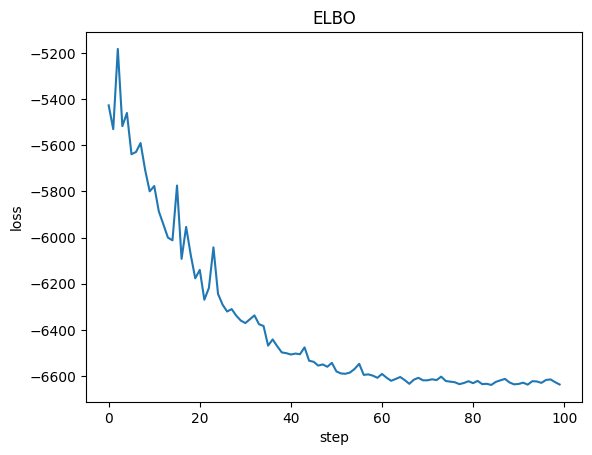

In [11]:
plot_loss(ll[0])

In [12]:
params = locate.learned_parameters_Clonal()

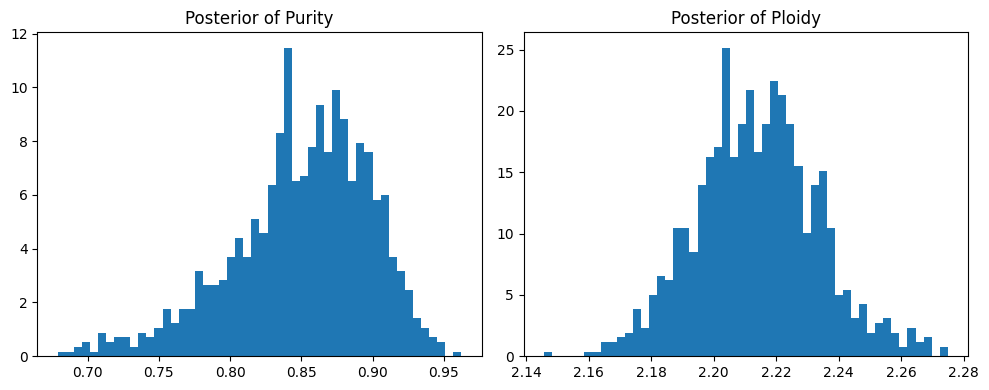

In [13]:
from locate.utils import plot_purity_ploidy_hist
draws = locate.posterior_draws(num_samples=1000, sites=["purity","ploidy"])
plot_purity_ploidy_hist(draws)

In [27]:
purity = params['purity']
ploidy = params['ploidy']
print(purity, ploidy)

[0.8486332] [2.2152872]


In [28]:
res_plot = pd.DataFrame({'CN_Major':params["CN_Major"]+0.05,
                    'CN_minor':params["CN_minor"]-0.05,
                    'pos':[i for i in range(len(params["CN_minor"]))]})

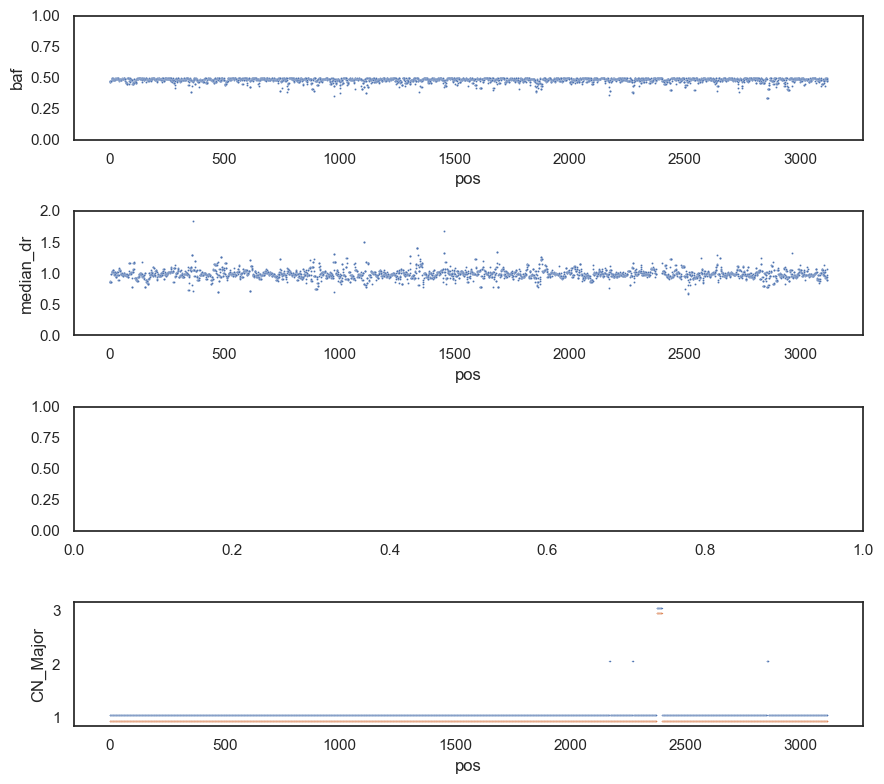

In [29]:
sns.set_theme(style="white", font_scale=1)
fig, axes = plt.subplots(4, 1, figsize=(9, 8))

baf = sns.scatterplot(data=data, x="pos", y="baf", s=2, ax=axes[0])
dr = sns.scatterplot(data=data, x="pos", y="median_dr", s=2, ax=axes[1])

cn = sns.scatterplot(data=res_plot, x="pos", y="CN_Major", s=1, ax=axes[3], legend=False)
cn = sns.scatterplot(data=res_plot, x="pos", y="CN_minor", s=1, ax=axes[3], legend=False)

axes[0].set_ylim(0,1) 
axes[1].set_ylim(0,2) 
axes[2].set_ylim(0,1) 

fig.tight_layout()

In [30]:
res = pd.DataFrame({'CN_Major':params["CN_Major"],
                    'CN_minor':params["CN_minor"],
                    'pos':[i for i in range(len(params["CN_minor"]))]})

In [31]:
import sys, os
sys.path.append(os.path.abspath(".."))

from scripts.ProCESS.infer_ProCESS import score_cn_predictions
out_df = score_cn_predictions(data, res, sample_name="sim_1")
out_df['summary']

,sample,n_positions,allelic_accuracy,total_cn_accuracy,total_cn_mae,precision_totalCN_macro,recall_totalCN_macro,f1_totalCN_macro,precision_pair_macro,recall_pair_macro,f1_pair_macro
0,sim_1,3118,0.99551,0.99551,0.006414,0.978099,0.976161,0.977128,0.978099,0.976161,0.977128


In [19]:
import numpy as np
import pandas as pd

def segment_allele_specific_cn(df, pos_col="pos",
                               major_col="CN_Major", minor_col="CN_minor"):
    df = df.sort_values(pos_col).reset_index(drop=True)
    change = ((df[major_col] != df[major_col].shift()) |
              (df[minor_col] != df[minor_col].shift()))
    seg_id = change.cumsum()
    segs = (df.groupby(seg_id)
              .agg(seg_start=(pos_col, "min"),
                   seg_end=(pos_col, "max"),
                   CN_major=(major_col, "first"),
                   CN_minor=(minor_col, "first"),
                   n_bins=(pos_col, "size"))
              .reset_index(drop=True))
    segs["length"] = segs["seg_end"] - segs["seg_start"] + 1
    segs["seg_id"] = np.arange(len(segs))
    return segs[["seg_id","seg_start","seg_end","length","n_bins","CN_major","CN_minor"]]

def _l1_dist(a_major, a_minor, b_major, b_minor):
    return abs(a_major - b_major) + abs(a_minor - b_minor)

def coalesce_same_cn(segs):
    """
    Merge consecutive segments that share the same (CN_major, CN_minor).
    Treat segments as mergeable if they are touching or overlapping.
    """
    if len(segs) <= 1:
        return segs.copy()

    s = segs.sort_values("seg_start").reset_index(drop=True).copy()
    out = []
    cur = s.iloc[0].to_dict()

    for i in range(1, len(s)):
        row = s.iloc[i]
        same_state = (row["CN_major"] == cur["CN_major"]) and (row["CN_minor"] == cur["CN_minor"])
        touching = row["seg_start"] <= cur["seg_end"] + 1  # contiguous or overlap
        if same_state and touching:
            # extend current
            cur["seg_end"] = max(cur["seg_end"], int(row["seg_end"]))
            cur["length"]  = cur["seg_end"] - cur["seg_start"] + 1
            cur["n_bins"]  = int(cur["n_bins"]) + int(row["n_bins"])
        else:
            out.append(cur)
            cur = row.to_dict()
    out.append(cur)

    out = pd.DataFrame(out).reset_index(drop=True)
    out["seg_id"] = np.arange(len(out))
    return out[["seg_id","seg_start","seg_end","length","n_bins","CN_major","CN_minor"]]

def merge_micro_segments(segs, min_bins=5, max_passes=100):
    """
    Merge segments shorter than min_bins into neighbors; after each pass,
    coalesce any newly adjacent equal-CN segments.
    """
    s = segs.sort_values("seg_start").reset_index(drop=True).copy()

    def _merge_once(s):
        if len(s) <= 1:
            return s, False
        short_idx = s.index[s["n_bins"] < min_bins].tolist()
        if not short_idx:
            return s, False

        to_drop = []
        for i in short_idx:
            if i in to_drop or i >= len(s):
                continue
            left = i - 1 if i - 1 >= 0 else None
            right = i + 1 if i + 1 < len(s) else None
            if left is None and right is None:
                continue

            target = None
            # Prefer identical state neighbor
            if left is not None and \
               (s.loc[left, "CN_major"] == s.loc[i, "CN_major"]) and \
               (s.loc[left, "CN_minor"] == s.loc[i, "CN_minor"]):
                target = left
            if right is not None and \
               (s.loc[right, "CN_major"] == s.loc[i, "CN_major"]) and \
               (s.loc[right, "CN_minor"] == s.loc[i, "CN_minor"]):
                if target is None or s.loc[right, "length"] > s.loc[target, "length"]:
                    target = right

            # Else closest L1 distance, tie -> larger length, tie -> left
            if target is None:
                candidates = []
                if left is not None:
                    dL = _l1_dist(s.loc[i,"CN_major"], s.loc[i,"CN_minor"],
                                  s.loc[left,"CN_major"], s.loc[left,"CN_minor"])
                    candidates.append(("L", left, dL, s.loc[left,"length"]))
                if right is not None:
                    dR = _l1_dist(s.loc[i,"CN_major"], s.loc[i,"CN_minor"],
                                  s.loc[right,"CN_major"], s.loc[right,"CN_minor"])
                    candidates.append(("R", right, dR, s.loc[right,"length"]))
                candidates.sort(key=lambda x: (x[2], -x[3], x[0]))
                target = candidates[0][1]

            # Merge i into target
            new_start = min(s.loc[i, "seg_start"], s.loc[target, "seg_start"])
            new_end   = max(s.loc[i, "seg_end"],   s.loc[target, "seg_end"])
            s.loc[target, "seg_start"] = new_start
            s.loc[target, "seg_end"]   = new_end
            s.loc[target, "length"]    = new_end - new_start + 1
            s.loc[target, "n_bins"]    = s.loc[target, "n_bins"] + s.loc[i, "n_bins"]
            to_drop.append(i)

        if not to_drop:
            return s, False

        s = s.drop(index=to_drop).sort_values("seg_start").reset_index(drop=True)
        # Coalesce equal-CN neighbors formed by this pass
        s = coalesce_same_cn(s)
        return s, True

    changed = True
    passes = 0
    while changed and passes < max_passes:
        s, changed = _merge_once(s)
        passes += 1

    # Final coalesce in case last pass only touched boundaries
    s = coalesce_same_cn(s)
    return s



In [20]:
segments = segment_allele_specific_cn(res)
segs_merged = merge_micro_segments(segments, min_bins=10)
print(segs_merged)

   seg_id  seg_start  seg_end  length  n_bins  CN_major  CN_minor
0       0          0     2375    2376    2376         1         1
1       1       2376     2398      23      23         3         3
2       2       2399     3118     720     720         1         1


In [21]:

# ---------- utilities ----------
def _vaf_mode(vafs, grid_n=199):
    v = np.asarray(vafs)
    v = v[np.isfinite(v)]
    if v.size == 0:
        return np.nan
    v = np.clip(v, 0.01, 0.99)
    g = np.linspace(0.01, 0.99, grid_n)
    std = np.std(v, ddof=1) if v.size > 1 else 0.05
    bw = max(0.01, 1.06 * std * v.size ** (-1/5))
    dens = np.exp(-0.5 * ((g[:, None] - v[None, :]) / bw) ** 2).sum(axis=1)
    return float(g[np.argmax(dens)])

def _expected_vafs(CNt, rho, m_cap=None):
    mmax = int(m_cap) if (m_cap is not None and np.isfinite(m_cap)) else int(CNt)
    mmax = max(1, mmax)
    m = np.arange(1, mmax + 1)
    denom = rho * CNt + (1 - rho) * 2
    return (rho * m) / denom

def _parse_seg_id_to_cols(seg_id_str):
    # format assumed: "{chr}:{start}:{end}:{CN_major}:{CN_minor}"
    # returns tuple (chr, start, end, CN_major, CN_minor) or None if it doesn't match
    if not isinstance(seg_id_str, str):
        return None
    parts = seg_id_str.split(":")
    if len(parts) != 5:
        return None
    try:
        chr_, start, end, maj, minor = parts[0], int(parts[1]), int(parts[2]), int(parts[3]), int(parts[4])
        return chr_, start, end, maj, minor
    except Exception:
        return None

# ---------- main ----------
def check_clonality_from_tables(segments, variants,
                                use_major_cap=True,
                                seg_chr_col="chr"):
    """
    segments: DataFrame with columns:
      seg_id, seg_start, seg_end, CN_major, CN_minor, purity, CN (total CN)
      (chr optional; if missing we infer from variants' seg_id)
    variants: DataFrame with columns:
      seg_id (string "chr:start:end:CN_major:CN_minor"), vaf, depth (optional)

    Returns: segments with clonal/subclonal call & confidence.
    """
    segs = segments.copy()

    # ensure total CN column name
    if "CN" in segs.columns:
        segs["CNt"] = segs["CN"]
    elif "CNt" in segs.columns:
        pass
    else:
        raise ValueError("segments must have a 'CN' or 'CNt' column (total CN).")

    # Try to attach a join key that matches variants' seg_id
    have_chr = seg_chr_col in segs.columns
    if have_chr:
        segs["join_key"] = (segs[seg_chr_col].astype(str) + ":" +
                            segs["seg_start"].astype(int).astype(str) + ":" +
                            segs["seg_end"].astype(int).astype(str) + ":" +
                            segs["CN_major"].astype(int).astype(str) + ":" +
                            segs["CN_minor"].astype(int).astype(str))
    else:
        # We'll parse variants seg_id and join on (start,end,maj,minor) only
        segs["join_key"] = (segs["seg_start"].astype(int).astype(str) + ":" +
                            segs["seg_end"].astype(int).astype(str) + ":" +
                            segs["CN_major"].astype(int).astype(str) + ":" +
                            segs["CN_minor"].astype(int).astype(str))

    # Prepare variants summary per segment
    var = variants.copy()
    # parse variants' seg_id to a joinable key
    parsed = var["seg_id"].apply(_parse_seg_id_to_cols)
    parsed_df = pd.DataFrame(parsed.tolist(), columns=["v_chr","v_start","v_end","v_maj","v_min"])
    var = pd.concat([var.reset_index(drop=True), parsed_df], axis=1)

    if have_chr:
        var["join_key"] = (var["v_chr"].astype(str) + ":" +
                           var["v_start"].astype("Int64").astype(str) + ":" +
                           var["v_end"].astype("Int64").astype(str) + ":" +
                           var["v_maj"].astype("Int64").astype(str) + ":" +
                           var["v_min"].astype("Int64").astype(str))
    else:
        var["join_key"] = (var["v_start"].astype("Int64").astype(str) + ":" +
                           var["v_end"].astype("Int64").astype(str) + ":" +
                           var["v_maj"].astype("Int64").astype(str) + ":" +
                           var["v_min"].astype("Int64").astype(str))

    # Summaries per variant segment-key
    if "depth" not in var.columns:
        var["depth"] = np.nan

    agg = (var.groupby("join_key", as_index=False)
              .agg(mode_vaf=('vaf', _vaf_mode),
                   n_snv=('vaf', 'size'),
                   depth_sum=('depth', lambda x: np.nansum(x))))

    # join to segments
    out = pd.merge(segs, agg, on="join_key", how="left")

    # compute expected clonal peak and status
    def _row_calc(row):
        CNt = row["CNt"]
        rho = row["purity"]
        if not np.isfinite(CNt) or not np.isfinite(rho):
            return pd.Series(dict(exp_vaf=np.nan, delta=np.nan, tol=0.05,
                                  status="unknown", confidence=0.0))
        m_cap = row["CN_major"] if use_major_cap else None
        exp_grid = _expected_vafs(CNt, rho, m_cap=m_cap)
        mode_vaf = row.get("mode_vaf", np.nan)
        if np.isnan(mode_vaf) or exp_grid.size == 0:
            return pd.Series(dict(exp_vaf=np.nan, delta=np.nan, tol=0.05,
                                  status="unknown", confidence=0.0))
        exp_vaf = float(exp_grid[np.argmin(np.abs(exp_grid - mode_vaf))])
        depth_sum = row.get("depth_sum", 0.0)
        eff_depth = max(20.0, float(depth_sum) if np.isfinite(depth_sum) else 0.0)
        tol = max(0.02, np.sqrt(exp_vaf * (1 - exp_vaf) / eff_depth))
        delta = abs(mode_vaf - exp_vaf)
        status = "clonal" if delta <= 2 * tol else "subclonal"
        confidence = float(np.exp(- (delta / tol) ** 2))
        return pd.Series(dict(exp_vaf=exp_vaf, delta=delta, tol=tol,
                              status=status, confidence=confidence))

    extra = out.apply(_row_calc, axis=1)
    res = pd.concat([out, extra], axis=1)

    # nice columns/order
    keep_cols = ["seg_id","seg_start","seg_end","n_bins","CN_major","CN_minor","CNt","purity",
                 "mode_vaf","exp_vaf","delta","tol","status","confidence","n_snv","depth_sum"]
    return res[[c for c in keep_cols if c in res.columns]].sort_values(["seg_start"]).reset_index(drop=True)


In [22]:
segs_merged['purity'] = purity[0]
segs_merged['CN'] = segs_merged['CN_major'] + segs_merged['CN_minor']

In [23]:
res = check_clonality_from_tables(segments=segs_merged, variants=data, use_major_cap=True)

In [24]:
res

,seg_id,seg_start,seg_end,n_bins,CN_major,CN_minor,CNt,purity,mode_vaf,exp_vaf,delta,tol,status,confidence,n_snv,depth_sum
0,0,0,2375,2376,1,1,2,0.848633,NaN,NaN,NaN,0.05,unknown,0.0,NaN,NaN
1,1,2376,2398,23,3,3,6,0.848633,NaN,NaN,NaN,0.05,unknown,0.0,NaN,NaN
2,2,2399,3118,720,1,1,2,0.848633,NaN,NaN,NaN,0.05,unknown,0.0,NaN,NaN


In [25]:
data

,chr,pos,ref,ALT,causes,classes,major,minor,ratio,seg_id,...,vaf,sample_name,to,mean_dr,mean_baf,median_dr,median_baf,mean_dp,median_dp,baf
0,22,1,T,C,SBS5,passenger,1,1,1,22:25201017:51304566:1:1,...,0.083333,Sample,51230404,0.871795,0.470588,0.871795,0.470588,68.000000,68.0,0.470588
1,22,2,C,A,SBS1,passenger,1,1,1,22:25201017:51304566:1:1,...,0.492308,Sample,51220469,0.862564,0.461857,0.862564,0.461857,66.000000,66.0,0.461857
2,22,3,A,C,SBS1,pre-neoplastic,1,1,1,22:25201017:51304566:1:1,...,0.460317,Sample,51218976,0.862564,0.461857,0.862564,0.461857,66.000000,66.0,0.461857
3,22,4,G,A,SBS5,passenger,1,1,1,22:25201017:51304566:1:1,...,0.067568,Sample,51211844,0.864685,0.492029,0.862564,0.471781,65.500000,66.0,0.471781
4,22,5,T,G,SBS5,passenger,1,1,1,22:25201017:51304566:1:1,...,0.493151,Sample,51211231,0.864685,0.492029,0.862564,0.471781,65.500000,66.0,0.471781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3114,22,3115,A,C,SBS5,passenger,1,1,1,22:1:24701016:1:1,...,0.067568,Sample,16118910,0.951436,0.522728,0.972973,0.517241,69.800000,72.0,0.482759
3115,22,3116,C,A,SBS1,passenger,1,1,1,22:1:24701016:1:1,...,0.064516,Sample,16106919,1.049059,0.525473,1.070876,0.528219,72.166667,73.0,0.471781
3116,22,3117,T,G,SBS5,passenger,1,1,1,22:1:24701016:1:1,...,0.057971,Sample,16087173,0.957952,0.494792,0.888889,0.494253,69.307692,68.0,0.494253
3117,22,3118,G,C,SBS1,passenger,1,1,1,22:1:24701016:1:1,...,0.466667,Sample,16082732,0.949882,0.487323,0.883634,0.492889,68.666667,66.5,0.492889
